# Introduction

**Paper link**- https://www.researchgate.net/profile/Bouchaib-Cherradi/publication/362504981_Brain_Tumor_Detection_using_MRI_Images_and_Convolutional_Neural_Network/links/633a275476e39959d69031a4/Brain-Tumor-Detection-using-MRI-Images-and-Convolutional-Neural-Network.pdf

This paper According to Table III in the paper, the proposed CNN model achieved an accuracy of ***96.33%*** in detecting and classifying brain tumors.


# **Dataset:**

Brain Tumor Classification (MRI) [dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) from kaggle

Data Explorer

Version 2 (93.08 MB)

 Type of Tumor have in dataset
*   glioma_tumor
*   meningioma_tumor
*   no_tumor
*   pituitary_tumor

**Authors**
Sartaj Bhuvaji


---

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dtpath = '/content/drive/MyDrive/Colab Notebooks/Datasets/Tumor'

Mounted at /content/drive


---

# Color

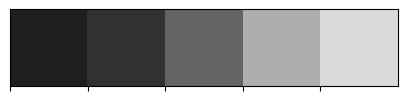

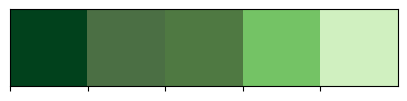

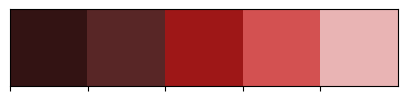

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join(dtpath, 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(dtpath, 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 74/74 [00:34<00:00,  2.14it/s]


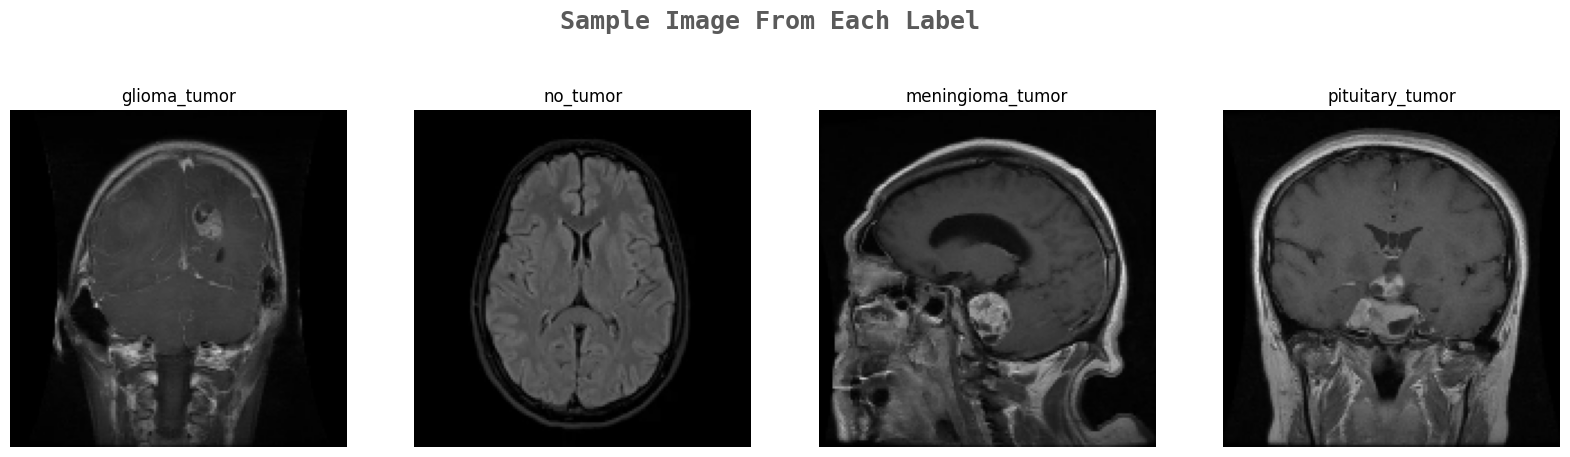

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3264, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8343
Epoch 1: val_accuracy improved from -inf to 0.87075, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 59s 192ms/step - loss: 0.4524 - accuracy: 0.8343 - val_loss: 0.4810 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9224
Epoch 2: val_accuracy improved from 0.87075 to 0.87755, saving model to effnet.h5
83/83 [==============================] - 12s 140ms/step - loss: 0.2205 - accuracy: 0.9224 - val_loss: 0.3912 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9569
Epoch 3: val_accuracy improved from 0.87755 to 0.95238, saving model to effnet.h5
83/83 [==============================] - 14s 172ms/step - loss: 0.1174 - accuracy: 0.9569 - val_loss: 0.2159 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9637
Epoch 4: val_accuracy did not improve from 0.95238
83/83 [==============================] - 11s 131ms/step - loss: 0.11

[0.8342792391777039, 0.9224366545677185, 0.9568672180175781, 0.9636776447296143, 0.9712448120117188, 0.9825955629348755, 0.9954596757888794, 0.9969731569290161, 0.9984865784645081, 0.9977298378944397, 0.9996216297149658, 0.9992432594299316]


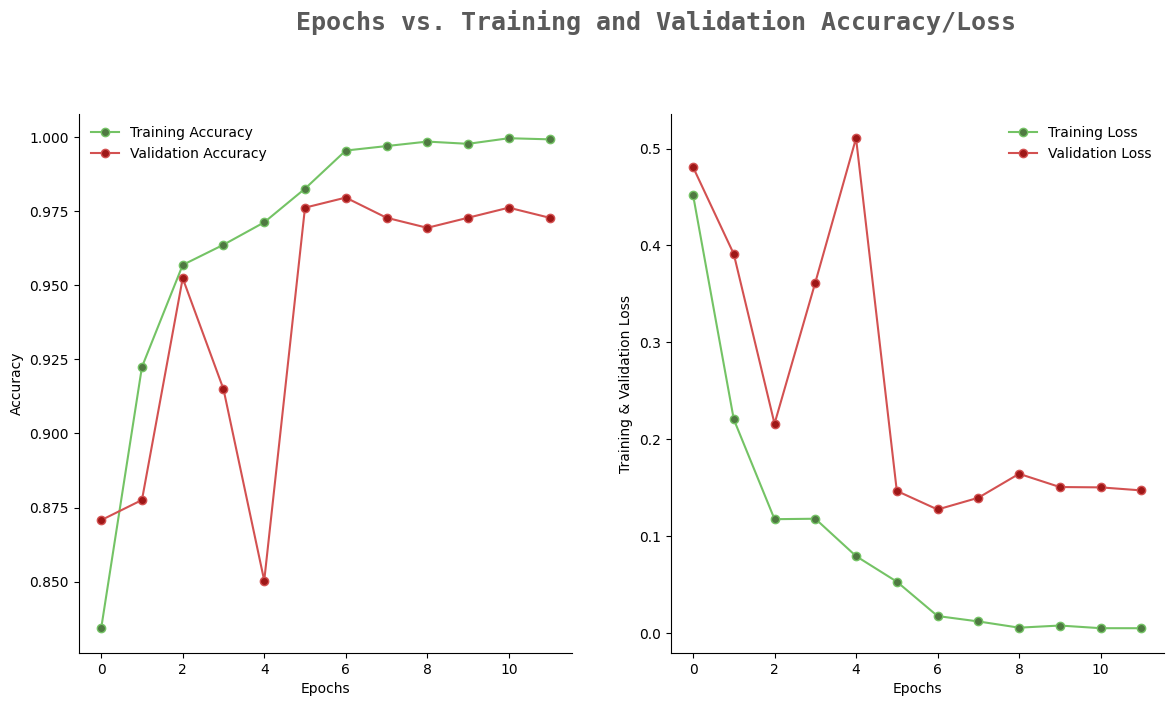

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()
print(train_acc)

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 4s 137ms/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        93
           1       0.98      1.00      0.99        51
           2       0.98      0.99      0.98        96
           3       1.00      1.00      1.00        87

    accuracy                           0.99       327
   macro avg       0.99      0.99      0.99       327
weighted avg       0.99      0.99      0.99       327



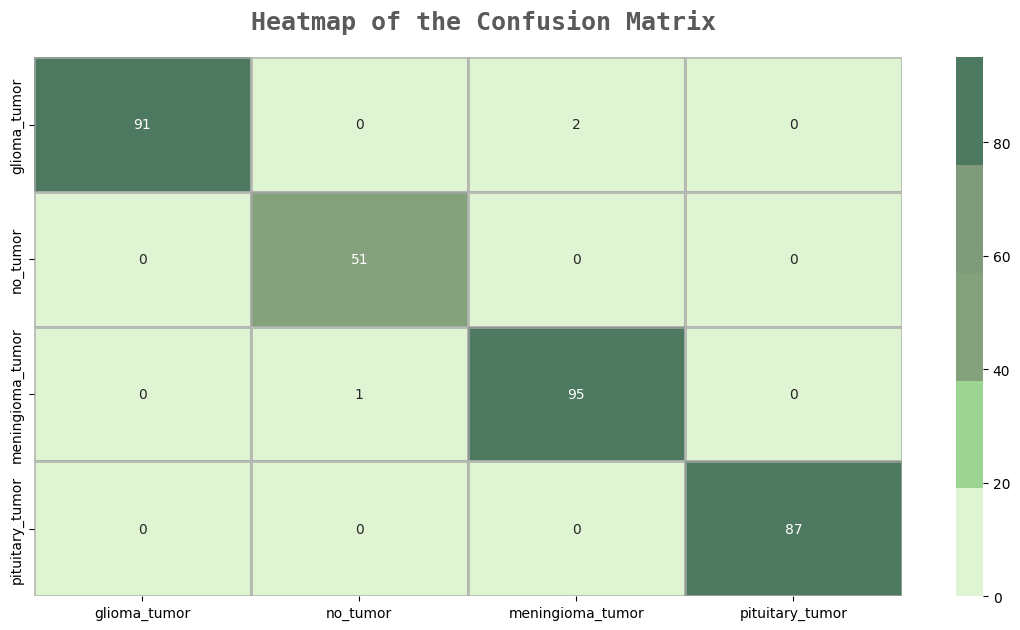

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()